In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score
)

from utils import get_data, calc_reconstruction_error

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('data/CC GENERAL.csv')
X.drop(columns=['CUST_ID'], inplace=True)
X.ffill(inplace=True)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# Split data into train and test sets.

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, _, _ = train_test_split(X, X, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Apply PCA with 2 components and KMeans

In [4]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 2
N_JOBS = -1

scaler = StandardScaler()
dim_redn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = KMeans(n_jobs=N_JOBS, n_init=100)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [5]:
results = {}
for n_clusters in range(2, 20):
    print(f"---------- n_clusters: {n_clusters} ----------")
    clus_pipeline.set_params(model__n_clusters=n_clusters)
    clus_pipeline.fit(X_train)
    
    # calc the sil_score based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    clus_labels = clus_pipeline.named_steps['model'].labels_
    sil_score = silhouette_score(X_dr, clus_labels)
    
    results[n_clusters] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}

---------- n_clusters: 2 ----------
---------- n_clusters: 3 ----------
---------- n_clusters: 4 ----------
---------- n_clusters: 5 ----------
---------- n_clusters: 6 ----------
---------- n_clusters: 7 ----------
---------- n_clusters: 8 ----------
---------- n_clusters: 9 ----------
---------- n_clusters: 10 ----------
---------- n_clusters: 11 ----------
---------- n_clusters: 12 ----------
---------- n_clusters: 13 ----------
---------- n_clusters: 14 ----------
---------- n_clusters: 15 ----------
---------- n_clusters: 16 ----------
---------- n_clusters: 17 ----------
---------- n_clusters: 18 ----------
---------- n_clusters: 19 ----------


<Axes: title={'center': 'Elbow plot'}, xlabel='n_clusters'>

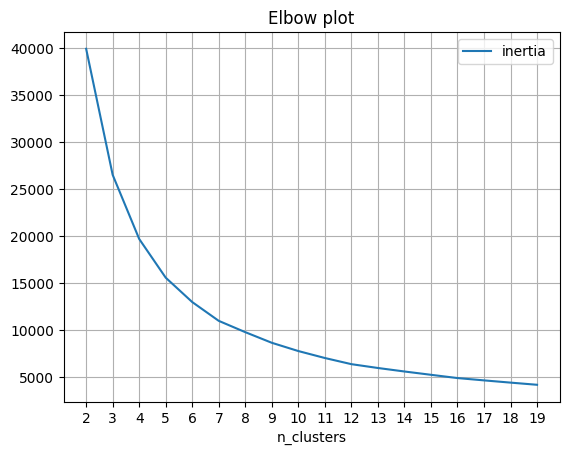

In [6]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_clusters', 'inertia', 'sil_score']
results_df.plot(x='n_clusters', y='inertia',title='Elbow plot', xticks=results_df['n_clusters'], grid=True)

<Axes: title={'center': 'Silhoutte Score'}, xlabel='n_clusters'>

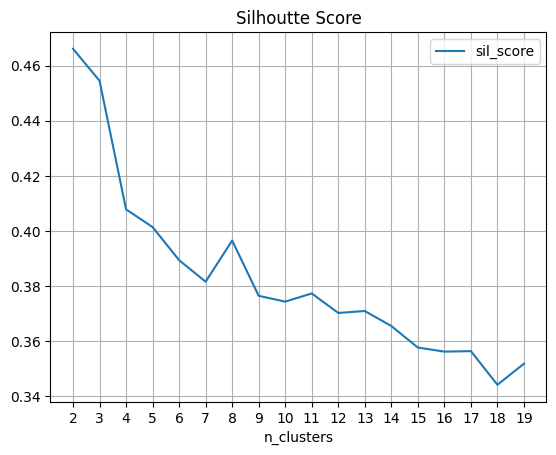

In [7]:
results_df.plot(x='n_clusters', y='sil_score',title='Silhoutte Score', xticks=results_df['n_clusters'], grid=True)

In [8]:
# Get the PCA transformed data
X_pca = clus_pipeline[:-1].transform(X_train)
X_pca.shape

(7160, 2)

In [9]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_clusters=5)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

centroids = clus_pipeline.named_steps['model'].cluster_centers_

(7160,)


Text(0.5, 1.0, 'KMeans(5) clustering with PCA(2), Dry Beans')

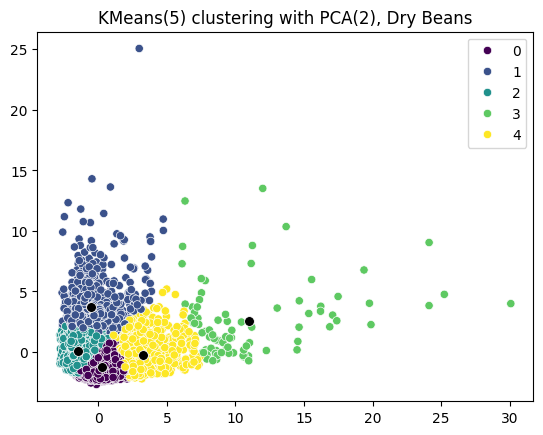

In [10]:
# Plot the clusters

fig, ax = plt.subplots()
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], color='black', s=50, marker='o', ax=ax)
ax.set_title("KMeans(5) clustering with PCA(2), Dry Beans")

# Apply ICA with 2 components and KMeans

In [11]:
RANDOM_STATE = 42
ICA_N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = FastICA(n_components=ICA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = KMeans(n_jobs=N_JOBS, n_init=100)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [12]:
results = {}
for n_clusters in range(2, 20):
    print(f"---------- n_clusters: {n_clusters} ----------")
    clus_pipeline.set_params(model__n_clusters=n_clusters)
    clus_pipeline.fit(X_train)
    
    # calc the sil_score based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    clus_labels = clus_pipeline.named_steps['model'].labels_
    sil_score = silhouette_score(X_dr, clus_labels)
    
    results[n_clusters] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}


---------- n_clusters: 2 ----------
---------- n_clusters: 3 ----------
---------- n_clusters: 4 ----------
---------- n_clusters: 5 ----------
---------- n_clusters: 6 ----------
---------- n_clusters: 7 ----------
---------- n_clusters: 8 ----------
---------- n_clusters: 9 ----------
---------- n_clusters: 10 ----------
---------- n_clusters: 11 ----------
---------- n_clusters: 12 ----------
---------- n_clusters: 13 ----------
---------- n_clusters: 14 ----------
---------- n_clusters: 15 ----------
---------- n_clusters: 16 ----------
---------- n_clusters: 17 ----------
---------- n_clusters: 18 ----------
---------- n_clusters: 19 ----------


<Axes: title={'center': 'Elbow plot'}, xlabel='n_clusters'>

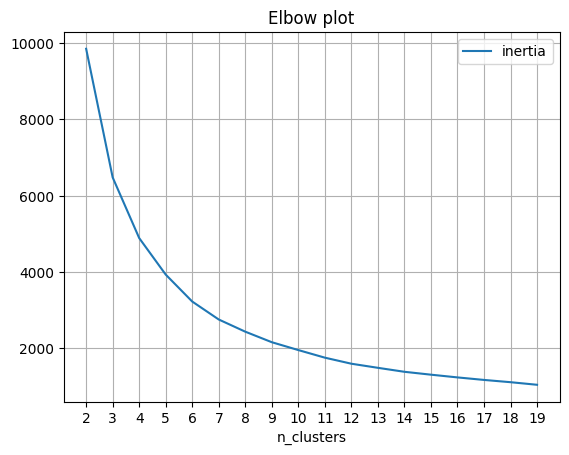

In [13]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_clusters', 'inertia', 'sil_score']
results_df.plot(x='n_clusters', y='inertia',title='Elbow plot', xticks=results_df['n_clusters'], grid=True)

<Axes: title={'center': 'Silhoutte Score'}, xlabel='n_clusters'>

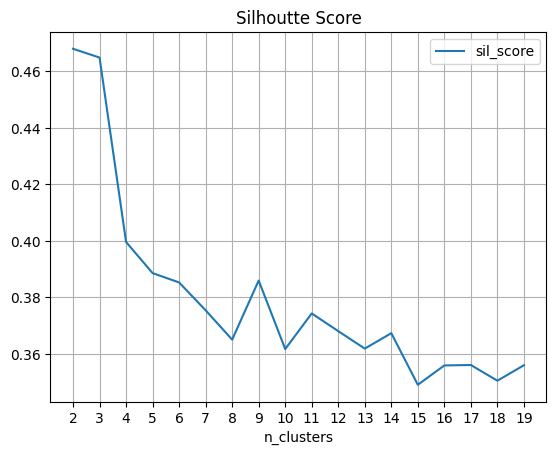

In [14]:
results_df.plot(x='n_clusters', y='sil_score',title='Silhoutte Score', xticks=results_df['n_clusters'], grid=True)

In [15]:
# Get the ICA transformed data
X_ica = clus_pipeline[:-1].fit_transform(X_train)
X_ica.shape

(7160, 2)

In [16]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_clusters=5)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

centroids = clus_pipeline.named_steps['model'].cluster_centers_

(7160,)


Text(0.5, 1.0, 'KMeans(5) clustering with ICA(2), Dry Beans')

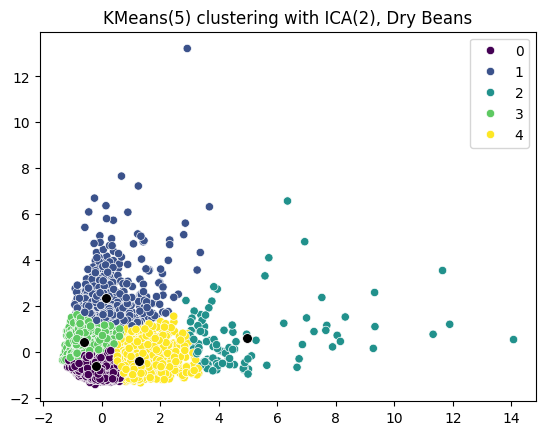

In [17]:
# Plot the clusters

fig, ax = plt.subplots()
sns.scatterplot(x=X_ica[:,0], y=X_ica[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], color='black', s=50, marker='o', ax=ax)
ax.set_title("KMeans(5) clustering with ICA(2), Dry Beans")

# Apply Gaussian projection

In [18]:
RANDOM_STATE = 42
N_COMPONENTS = 2
N_JOBS = -1

scaler = StandardScaler()
dim_redn = GaussianRandomProjection(n_components=2, random_state=RANDOM_STATE)
clus = KMeans(n_jobs=N_JOBS, n_init=100)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])

In [19]:
results = {}
for n_clusters in range(2, 20):
    print(f"---------- n_clusters: {n_clusters} ----------")
    clus_pipeline.set_params(model__n_clusters=n_clusters)
    clus_pipeline.fit(X_train)
    
    # calc the sil_score based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    clus_labels = clus_pipeline.named_steps['model'].labels_
    sil_score = silhouette_score(X_dr, clus_labels)
    
    results[n_clusters] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}


---------- n_clusters: 2 ----------
---------- n_clusters: 3 ----------
---------- n_clusters: 4 ----------
---------- n_clusters: 5 ----------
---------- n_clusters: 6 ----------
---------- n_clusters: 7 ----------
---------- n_clusters: 8 ----------
---------- n_clusters: 9 ----------
---------- n_clusters: 10 ----------
---------- n_clusters: 11 ----------
---------- n_clusters: 12 ----------
---------- n_clusters: 13 ----------
---------- n_clusters: 14 ----------
---------- n_clusters: 15 ----------
---------- n_clusters: 16 ----------
---------- n_clusters: 17 ----------
---------- n_clusters: 18 ----------
---------- n_clusters: 19 ----------


<Axes: title={'center': 'Elbow plot'}, xlabel='n_clusters'>

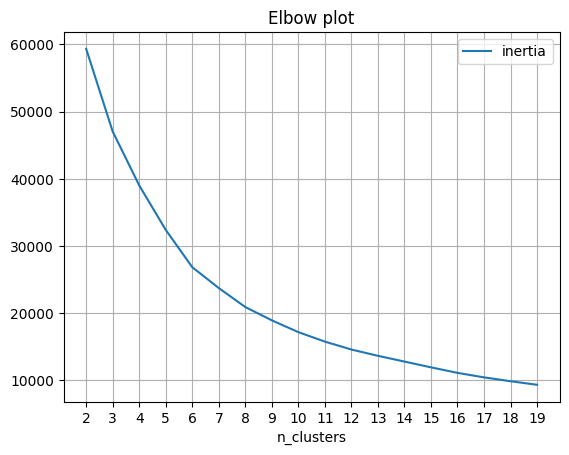

In [20]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_clusters', 'inertia', 'sil_score']
results_df.plot(x='n_clusters', y='inertia',title='Elbow plot', xticks=results_df['n_clusters'], grid=True)

<Axes: title={'center': 'Silhoutte Score'}, xlabel='n_clusters'>

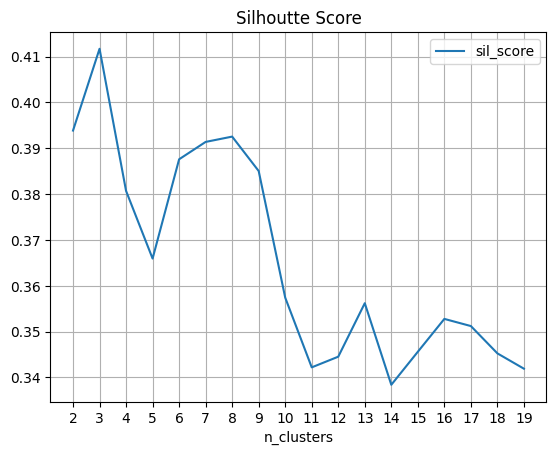

In [21]:
results_df.plot(x='n_clusters', y='sil_score',title='Silhoutte Score', xticks=results_df['n_clusters'], grid=True)

In [22]:
# Get the Gauss Rand Proj transformed data
X_rand = clus_pipeline[:-1].fit_transform(X_train)
X_rand.shape

(7160, 2)

In [23]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_clusters=5)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

centroids = clus_pipeline.named_steps['model'].cluster_centers_

(7160,)


Text(0.5, 1.0, 'KMeans(5) clustering with Gaussian Rand Proj(2), Dry Beans')

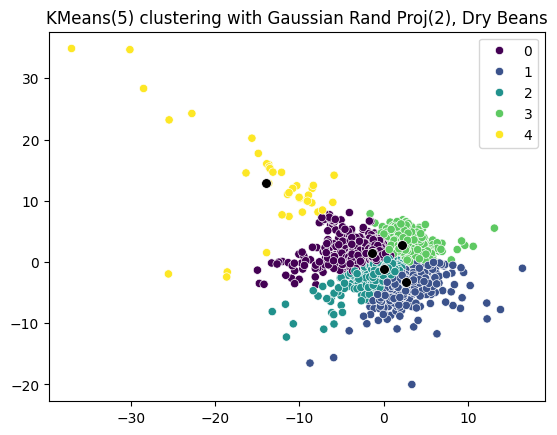

In [24]:
# Plot the clusters

fig, ax = plt.subplots()
sns.scatterplot(x=X_rand[:,0], y=X_rand[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], color='black', s=50, marker='o', ax=ax)
ax.set_title("KMeans(5) clustering with Gaussian Rand Proj(2), Dry Beans")

# Apply t-SNE

In [25]:
RANDOM_STATE = 42
T_SNE_N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = TSNE(random_state=RANDOM_STATE)
clus = KMeans(n_jobs=N_JOBS, n_init=100)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
])



In [26]:
X_tsne = dr_pipeline.fit_transform(X_train)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [27]:
results = {}
for n_clusters in range(2, 20):
    print(f"---------- n_clusters: {n_clusters} ----------")
    model = KMeans(n_jobs=N_JOBS, n_init=100, n_clusters=n_clusters)
    model.fit(X_tsne)
    
    clus_labels = model.labels_
    sil_score = silhouette_score(X_tsne, clus_labels)
    
    results[n_clusters] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}

---------- n_clusters: 2 ----------
---------- n_clusters: 3 ----------
---------- n_clusters: 4 ----------
---------- n_clusters: 5 ----------
---------- n_clusters: 6 ----------
---------- n_clusters: 7 ----------
---------- n_clusters: 8 ----------
---------- n_clusters: 9 ----------
---------- n_clusters: 10 ----------
---------- n_clusters: 11 ----------
---------- n_clusters: 12 ----------
---------- n_clusters: 13 ----------
---------- n_clusters: 14 ----------
---------- n_clusters: 15 ----------
---------- n_clusters: 16 ----------
---------- n_clusters: 17 ----------
---------- n_clusters: 18 ----------
---------- n_clusters: 19 ----------


<Axes: title={'center': 'Elbow plot'}, xlabel='n_clusters'>

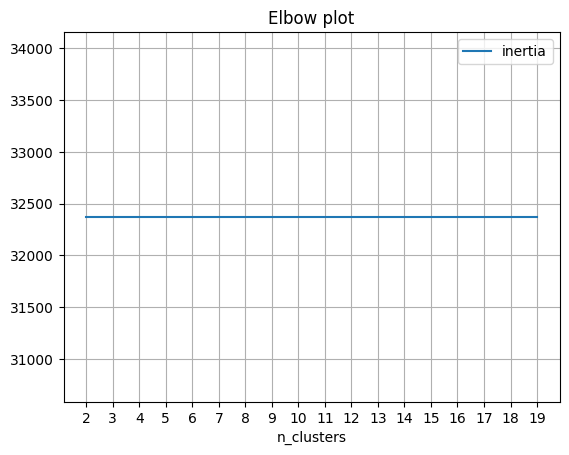

In [28]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_clusters', 'inertia', 'sil_score']
results_df.plot(x='n_clusters', y='inertia',title='Elbow plot', xticks=results_df['n_clusters'], grid=True)

<Axes: title={'center': 'Silhoutte Score'}, xlabel='n_clusters'>

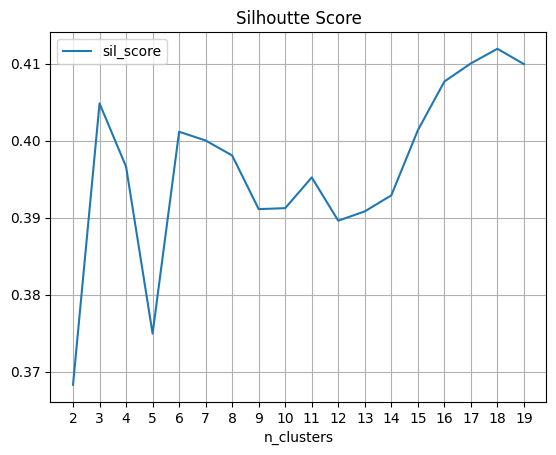

In [29]:
results_df.plot(x='n_clusters', y='sil_score',title='Silhoutte Score', xticks=results_df['n_clusters'], grid=True)

In [30]:
#  Get the K-means labels and centroids
model = KMeans(n_jobs=N_JOBS, n_init=100, n_clusters=5)
label = model.fit_predict(X_tsne)

print(label.shape)

centroids = model.cluster_centers_

(7160,)


Text(0.5, 1.0, 'KMeans(5) clustering with T-SNE(2), Dry Beans')

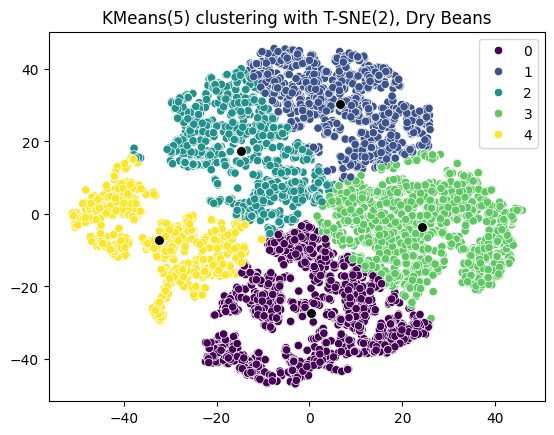

In [31]:
# Plot the clusters

fig, ax = plt.subplots()
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], color='black', s=50, marker='o', ax=ax)
ax.set_title("KMeans(5) clustering with T-SNE(2), Dry Beans")